# Controlled Validation Experiments (Updated)

Validating the **corrected** formula:
$$T^* = 1 + \frac{\sigma^2}{\text{Var}_p(z)}$$

**Tests:**
1. Basic formula validation
2. Distribution robustness
3. Comparison: new formula vs old √(1+α)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize_scalar

np.random.seed(42)

def kl_divergence(p, q, eps=1e-10):
    """KL(p || q)"""
    return np.sum(p * np.log(p / np.clip(q, eps, 1)))

def var_p(z, p):
    """Variance of z weighted by softmax probabilities p"""
    return np.sum(p * z**2) - (np.sum(p * z))**2

def find_optimal_temperature(z_clean, z_noisy, t_range=(0.5, 3.0)):
    """Find T that minimizes KL(softmax(z_clean) || softmax(z_noisy/T))"""
    p_clean = softmax(z_clean)
    
    def objective(t):
        p_noisy = softmax(z_noisy / t)
        return kl_divergence(p_clean, p_noisy)
    
    result = minimize_scalar(objective, bounds=t_range, method='bounded')
    return result.x, result.fun

print('Ready!')

Ready!


---
## Part 1: Basic Formula Validation

**New formula:** $T^* = 1 + \sigma^2 / \text{Var}_p(z)$

**Simplified:** $T^* \approx 1 + \alpha$ when $\text{Var}_p(z) \approx \tau^2$

In [2]:
def test_new_formula(vocab_size=1000, num_trials=100):
    """Test T* = 1 + σ²/Var_p(z)"""
    
    noise_scales = [0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 0.70, 1.00]
    results = []
    
    for sigma in noise_scales:
        t_pred_exact_list = []
        t_pred_simple_list = []
        t_pred_old_list = []
        t_empirical_list = []
        alpha_list = []
        
        for _ in range(num_trials):
            # Generate clean logits
            z = np.random.randn(vocab_size)
            p = softmax(z)
            tau2 = z.var()
            
            # Add noise
            noise = np.random.randn(vocab_size) * sigma * z.std()
            z_noisy = z + noise
            sigma2 = noise.var()
            
            # Compute alpha
            alpha = sigma2 / tau2
            alpha_list.append(alpha)
            
            # Var_p(z)
            A = var_p(z, p)
            
            # Three predictions
            t_pred_exact = 1 + sigma2 / A          # New exact formula
            t_pred_simple = 1 + alpha              # New simplified
            t_pred_old = np.sqrt(1 + alpha)        # Old (variance matching)
            
            t_pred_exact_list.append(t_pred_exact)
            t_pred_simple_list.append(t_pred_simple)
            t_pred_old_list.append(t_pred_old)
            
            # Find optimal temperature
            t_opt, _ = find_optimal_temperature(z, z_noisy)
            t_empirical_list.append(t_opt)
        
        results.append({
            'sigma': sigma,
            'alpha': np.mean(alpha_list),
            't_exact': np.mean(t_pred_exact_list),
            't_simple': np.mean(t_pred_simple_list),
            't_old': np.mean(t_pred_old_list),
            't_emp': np.mean(t_empirical_list),
            't_std': np.std(t_empirical_list),
        })
    
    return results

print('Part 1: Testing T* = 1 + σ²/Var_p(z)')
print('='*90)

results = test_new_formula()

print(f"{'σ':<6} {'α':<8} {'T* emp':<10} {'Exact':<10} {'1+α':<10} {'√(1+α)':<10} {'Err(exact)':<12} {'Err(old)'}")
print('-'*85)
for r in results:
    err_exact = abs(r['t_exact'] - r['t_emp'])
    err_old = abs(r['t_old'] - r['t_emp'])
    better = '✓' if err_exact < err_old else ''
    print(f"{r['sigma']:<6.2f} {r['alpha']:<8.4f} {r['t_emp']:<10.4f} {r['t_exact']:<10.4f} {r['t_simple']:<10.4f} {r['t_old']:<10.4f} {err_exact:<12.4f} {err_old:.4f} {better}")

Part 1: Testing T* = 1 + σ²/Var_p(z)
σ      α        T* emp     Exact      1+α        √(1+α)     Err(exact)   Err(old)
-------------------------------------------------------------------------------------
0.05   0.0025   1.0027     1.0026     1.0025     1.0012     0.0001       0.0014 ✓
0.10   0.0100   1.0096     1.0103     1.0100     1.0050     0.0008       0.0046 ✓
0.15   0.0225   1.0227     1.0229     1.0225     1.0112     0.0001       0.0115 ✓
0.20   0.0399   1.0414     1.0407     1.0399     1.0197     0.0006       0.0216 ✓
0.30   0.0899   1.0939     1.0931     1.0899     1.0440     0.0008       0.0499 ✓
0.50   0.2512   1.2541     1.2542     1.2512     1.1186     0.0001       0.1355 ✓
0.70   0.4889   1.4978     1.5019     1.4889     1.2202     0.0041       0.2776 ✓
1.00   1.0011   2.0097     2.0138     2.0011     1.4145     0.0041       0.5952 ✓


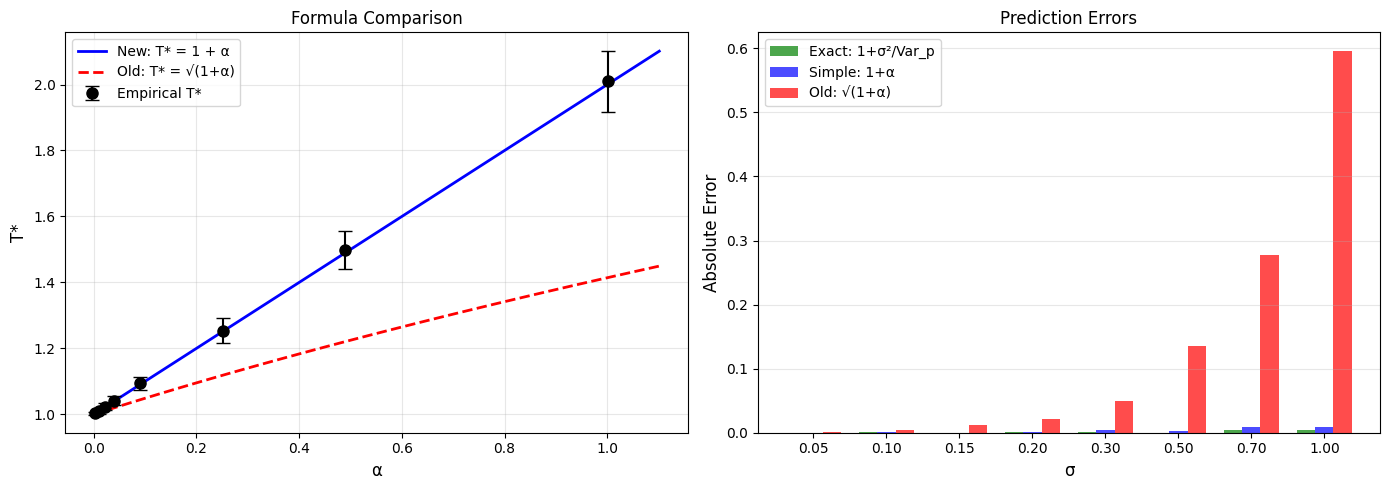


Mean errors:
  Exact (1+σ²/Var_p): 0.0013
  Simple (1+α):       0.0034
  Old (√(1+α)):       0.1372


In [3]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = [r['alpha'] for r in results]
t_emps = [r['t_emp'] for r in results]
t_exacts = [r['t_exact'] for r in results]
t_simples = [r['t_simple'] for r in results]
t_olds = [r['t_old'] for r in results]
t_stds = [r['t_std'] for r in results]

# Left: T* vs α
ax1 = axes[0]
ax1.errorbar(alphas, t_emps, yerr=t_stds, fmt='ko', capsize=5, markersize=8, label='Empirical T*', zorder=10)

alpha_smooth = np.linspace(0, max(alphas)*1.1, 100)
ax1.plot(alpha_smooth, 1 + alpha_smooth, 'b-', linewidth=2, label='New: T* = 1 + α')
ax1.plot(alpha_smooth, np.sqrt(1 + alpha_smooth), 'r--', linewidth=2, label='Old: T* = √(1+α)')

ax1.set_xlabel('α', fontsize=12)
ax1.set_ylabel('T*', fontsize=12)
ax1.set_title('Formula Comparison', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Errors
ax2 = axes[1]
err_exact = [abs(r['t_exact'] - r['t_emp']) for r in results]
err_simple = [abs(r['t_simple'] - r['t_emp']) for r in results]
err_old = [abs(r['t_old'] - r['t_emp']) for r in results]

x = np.arange(len(results))
width = 0.25
ax2.bar(x - width, err_exact, width, label='Exact: 1+σ²/Var_p', color='green', alpha=0.7)
ax2.bar(x, err_simple, width, label='Simple: 1+α', color='blue', alpha=0.7)
ax2.bar(x + width, err_old, width, label='Old: √(1+α)', color='red', alpha=0.7)

ax2.set_xticks(x)
ax2.set_xticklabels([f"{r['sigma']:.2f}" for r in results])
ax2.set_xlabel('σ', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Prediction Errors', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('formula_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMean errors:")
print(f"  Exact (1+σ²/Var_p): {np.mean(err_exact):.4f}")
print(f"  Simple (1+α):       {np.mean(err_simple):.4f}")
print(f"  Old (√(1+α)):       {np.mean(err_old):.4f}")

---
## Part 2: Distribution Robustness

Test that the formula works across different logit distributions.

In [4]:
def test_distributions(sigma=0.2, vocab_size=1000, num_trials=100):
    """Test formula across different logit distributions"""
    
    distributions = {
        'N(0,1)': lambda: np.random.randn(vocab_size),
        'N(0,0.5)': lambda: np.random.randn(vocab_size) * 0.5,
        'N(0,2)': lambda: np.random.randn(vocab_size) * 2,
        'N(5,1)': lambda: np.random.randn(vocab_size) + 5,
        'Uniform': lambda: np.random.uniform(-1, 1, vocab_size),
        'Exponential': lambda: np.random.exponential(1, vocab_size),
        'Bimodal': lambda: np.concatenate([np.random.randn(vocab_size//2) - 2, 
                                           np.random.randn(vocab_size//2) + 2]),
    }
    
    results = []
    
    for name, generator in distributions.items():
        t_pred_list = []
        t_emp_list = []
        
        for _ in range(num_trials):
            z = generator()
            p = softmax(z)
            
            noise = np.random.randn(vocab_size) * sigma * z.std()
            z_noisy = z + noise
            sigma2 = noise.var()
            
            # Exact formula
            A = var_p(z, p)
            t_pred = 1 + sigma2 / A
            t_pred_list.append(t_pred)
            
            # Empirical
            t_opt, _ = find_optimal_temperature(z, z_noisy)
            t_emp_list.append(t_opt)
        
        results.append({
            'distribution': name,
            't_pred': np.mean(t_pred_list),
            't_emp': np.mean(t_emp_list),
            't_std': np.std(t_emp_list),
            'error': abs(np.mean(t_pred_list) - np.mean(t_emp_list)),
        })
    
    return results

print('Part 2: Distribution Robustness (σ=0.2)')
print('='*65)

results_dist = test_distributions()

print(f"{'Distribution':<15} {'T* pred':<12} {'T* emp':<12} {'Error':<10} {'Match?'}")
print('-'*55)
for r in results_dist:
    match = '✓' if r['error'] < 0.01 else ('~' if r['error'] < 0.02 else '✗')
    print(f"{r['distribution']:<15} {r['t_pred']:<12.4f} {r['t_emp']:<12.4f} {r['error']:<10.4f} {match}")

Part 2: Distribution Robustness (σ=0.2)
Distribution    T* pred      T* emp       Error      Match?
-------------------------------------------------------
N(0,1)          1.0398       1.0397       0.0001     ✓
N(0,0.5)        1.0399       1.0399       0.0001     ✓
N(0,2)          1.0511       1.0433       0.0078     ✓
N(5,1)          1.0407       1.0392       0.0015     ✓
Uniform         1.0483       1.0468       0.0015     ✓
Exponential     1.0079       1.0023       0.0057     ✓
Bimodal         1.1641       1.1486       0.0155     ~


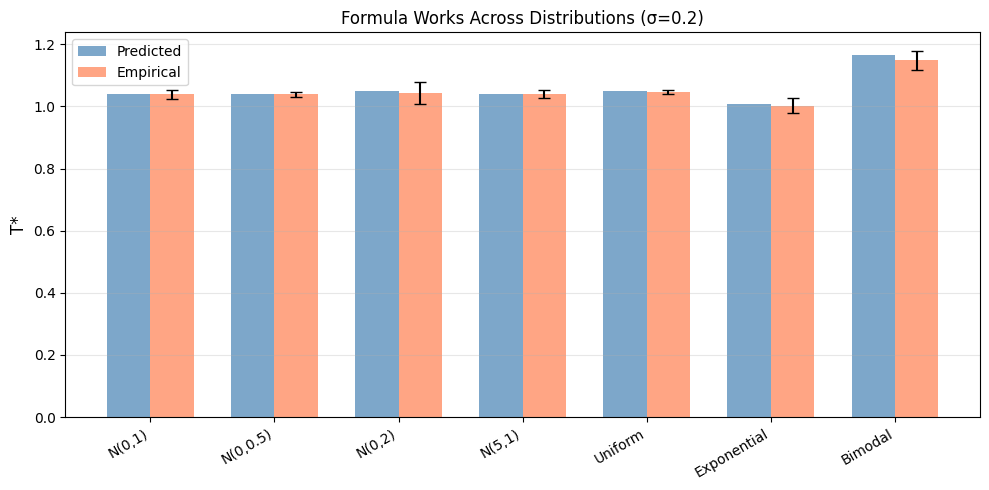


Mean error across distributions: 0.0046


In [5]:
# Plot distribution robustness
fig, ax = plt.subplots(figsize=(10, 5))

names = [r['distribution'] for r in results_dist]
t_preds = [r['t_pred'] for r in results_dist]
t_emps = [r['t_emp'] for r in results_dist]
t_stds = [r['t_std'] for r in results_dist]

x = np.arange(len(names))
width = 0.35

ax.bar(x - width/2, t_preds, width, label='Predicted', color='steelblue', alpha=0.7)
ax.bar(x + width/2, t_emps, width, yerr=t_stds, capsize=4, label='Empirical', color='coral', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha='right')
ax.set_ylabel('T*', fontsize=12)
ax.set_title('Formula Works Across Distributions (σ=0.2)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('distribution_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMean error across distributions: {np.mean([r['error'] for r in results_dist]):.4f}")

---
## Part 3: When does Var_p(z) ≈ τ²?

In [6]:
print('Part 3: When is Var_p(z) ≈ τ²?')
print('='*60)

num_trials = 200

# Test vocab sizes
print('\n3a. Effect of vocabulary size:')
print(f"{'Vocab':<10} {'Var_p(z)':<12} {'τ²':<12} {'Ratio'}")
print('-'*45)

for vocab in [100, 500, 1000, 5000, 10000]:
    ratios = []
    for _ in range(num_trials):
        z = np.random.randn(vocab)
        p = softmax(z)
        ratios.append(var_p(z, p) / z.var())
    print(f"{vocab:<10} {np.mean(ratios)*np.mean([z.var() for _ in range(10)]):<12.4f} {1.0:<12.4f} {np.mean(ratios):.4f}")

# Test logit scales
print('\n3b. Effect of logit scale (vocab=1000):')
print(f"{'Scale':<10} {'Var_p(z)':<12} {'τ²':<12} {'Ratio'}")
print('-'*45)

for scale in [0.5, 1.0, 2.0, 3.0, 5.0]:
    var_p_list = []
    tau2_list = []
    for _ in range(num_trials):
        z = np.random.randn(1000) * scale
        p = softmax(z)
        var_p_list.append(var_p(z, p))
        tau2_list.append(z.var())
    ratio = np.mean(var_p_list) / np.mean(tau2_list)
    print(f"{scale:<10.1f} {np.mean(var_p_list):<12.4f} {np.mean(tau2_list):<12.4f} {ratio:.4f}")

print('\n→ Var_p(z) ≈ τ² when vocab is large and logit scale ≈ 1')
print('→ For large logits, softmax becomes peaky and Var_p(z) << τ²')

Part 3: When is Var_p(z) ≈ τ²?

3a. Effect of vocabulary size:
Vocab      Var_p(z)     τ²           Ratio
---------------------------------------------
100        0.9994       1.0000       0.9291
500        0.9600       1.0000       0.9826
1000       0.9787       1.0000       0.9930
5000       1.0333       1.0000       0.9963
10000      0.9993       1.0000       0.9984

3b. Effect of logit scale (vocab=1000):
Scale      Var_p(z)     τ²           Ratio
---------------------------------------------
0.5        0.2494       0.2492       1.0009
1.0        0.9945       0.9982       0.9964
2.0        3.4751       3.9986       0.8691
3.0        4.0081       8.9807       0.4463
5.0        2.3947       24.9889      0.0958

→ Var_p(z) ≈ τ² when vocab is large and logit scale ≈ 1
→ For large logits, softmax becomes peaky and Var_p(z) << τ²


---
## Summary

In [7]:
print('='*70)
print('SUMMARY')
print('='*70)

# Compute errors
err_exact = [abs(r['t_exact'] - r['t_emp']) for r in results]
err_simple = [abs(r['t_simple'] - r['t_emp']) for r in results]
err_old = [abs(r['t_old'] - r['t_emp']) for r in results]

print(f"""
CORRECT FORMULA:
  Exact:      T* = 1 + σ²/Var_p(z)
  Simplified: T* ≈ 1 + α (when Var_p(z) ≈ τ²)

WRONG FORMULA (variance matching):
  T* = √(1+α) ≈ 1 + α/2  ← underestimates by ~2×

MEAN ERRORS:
  Exact formula:  {np.mean(err_exact):.4f}
  Simplified 1+α: {np.mean(err_simple):.4f}
  Old √(1+α):     {np.mean(err_old):.4f}

KEY INSIGHT:
  Variance matching works in logit space (uniform weights)
  KL minimization works in probability space (softmax weights)
  The softmax nonlinearity causes the factor of 2 difference.
""")

print('='*70)
print('FOR PAPER TABLE:')
print('='*70)
print(f"\n{'σ':<8} {'α':<10} {'T*_pred':<12} {'T*_emp':<12} {'Error':<10} {'Rel.Err'}")
print('-'*60)
for r in results:
    err = abs(r['t_exact'] - r['t_emp'])
    rel_err = err / r['t_emp'] * 100
    print(f"{r['sigma']:<8.2f} {r['alpha']:<10.4f} {r['t_exact']:<12.4f} {r['t_emp']:<12.4f} {err:<10.4f} {rel_err:.1f}%")

SUMMARY

CORRECT FORMULA:
  Exact:      T* = 1 + σ²/Var_p(z)
  Simplified: T* ≈ 1 + α (when Var_p(z) ≈ τ²)

WRONG FORMULA (variance matching):
  T* = √(1+α) ≈ 1 + α/2  ← underestimates by ~2×

MEAN ERRORS:
  Exact formula:  0.0013
  Simplified 1+α: 0.0034
  Old √(1+α):     0.1372

KEY INSIGHT:
  Variance matching works in logit space (uniform weights)
  KL minimization works in probability space (softmax weights)
  The softmax nonlinearity causes the factor of 2 difference.

FOR PAPER TABLE:

σ        α          T*_pred      T*_emp       Error      Rel.Err
------------------------------------------------------------
0.05     0.0025     1.0026       1.0027       0.0001     0.0%
0.10     0.0100     1.0103       1.0096       0.0008     0.1%
0.15     0.0225     1.0229       1.0227       0.0001     0.0%
0.20     0.0399     1.0407       1.0414       0.0006     0.1%
0.30     0.0899     1.0931       1.0939       0.0008     0.1%
0.50     0.2512     1.2542       1.2541       0.0001     0.0%
0.70